<a href="https://colab.research.google.com/github/minhtripham9/sarcasm-detection/blob/master/Code/byt5-DS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## byt5-DS2

### Managing imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm



## Without context

#### Loading dataset 2

In [2]:
# Only read the first 4400 rows and specific columns
cols_to_use = ['label', 'comment', 'parent_comment']

df = pd.read_csv('Dataset/train-balanced-sarcasm.csv', usecols=cols_to_use, nrows=4400)

# Rename columns
df = df.rename(columns={
    'comment': 'response',
    'parent_comment': 'context'
})

df


,label,response,context
0,1,That's exactly what a country who made up a ho...,China Tells Trump That Climate Change Is No Ho...
1,1,but it still snows,Facts for those who dispute man-made climate c...
2,0,"lol, you can't make this stuff up.","""Suppression of dissent is about as facist as ..."
3,0,He didn't drink the compliance,"The Worst ""Got Talent"" Judges Go on a Power Trip"
4,0,"In the Half Life series, the reason Gordon Fre...",What 'fan theories' have blown your mind with ...
...,...,...,...
4395,1,"Not to be sexist but uhhhh, stupid women have ...","""Not tryna be racist but uhhh"""
4396,0,He's opposed only when they don't pick him.,Wait wait. Please. Let me stop laughing at the...
4397,0,Round Aboot.,Canadian Solution to SimCity's Round-about Pro...
4398,0,That's some pretty impressive camouflage though.,As a hunter i find this super pathetic.


#### Preparing dataset 2

In [3]:
df['input_text'] = df['response']

# Check the result
print(df[['input_text', 'label']].head())

                                          input_text  label
0  That's exactly what a country who made up a ho...      1
1                                 but it still snows      1
2                 lol, you can't make this stuff up.      0
3                     He didn't drink the compliance      0
4  In the Half Life series, the reason Gordon Fre...      0


In [4]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df['input_text'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)

train_df = pd.DataFrame({'input_text': X_train, 'label': y_train})
test_df = pd.DataFrame({'input_text': X_test, 'label': y_test})

print("Train and test splits saved!")

Train and test splits saved!


#### Training

In [5]:
train_df['input_text'] = train_df['input_text'].fillna("").astype(str)
test_df['input_text'] = test_df['input_text'].fillna("").astype(str)

X_train_byt5 = train_df['input_text'].tolist()
y_train_byt5 = train_df['label'].tolist()
X_test_byt5 = test_df['input_text'].tolist()
y_test_byt5 = test_df['label'].tolist()

In [6]:
tokenizer = AutoTokenizer.from_pretrained("google/byt5-small")

def tokenize(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,         # You can adjust for your dataset
        return_tensors='pt'
    )

X_train_enc_byt5 = tokenize(X_train_byt5)
X_test_enc_byt5 = tokenize(X_test_byt5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
train_dataset_byt5 = TensorDataset(
    X_train_enc_byt5['input_ids'],
    X_train_enc_byt5['attention_mask'],
    torch.tensor(y_train_byt5)
)

test_dataset_byt5 = TensorDataset(
    X_test_enc_byt5['input_ids'],
    X_test_enc_byt5['attention_mask'],
    torch.tensor(y_test_byt5)
)

In [8]:
batch_size = 24

train_loader = DataLoader(train_dataset_byt5, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_byt5, batch_size=batch_size)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained("google/byt5-small", num_labels=2)
model = model.to(device)

In [12]:
optimizer = AdamW(model.parameters(), lr=3e-5)

#### Training loop


In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

model.save_pretrained('byt5_no_context_2')

#### Evaluation

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained('byt5_no_context_2')
model = model.to(device)

               precision    recall  f1-score   support

Not Sarcastic       0.63      0.89      0.74       501
    Sarcastic       0.67      0.31      0.42       379

     accuracy                           0.64       880
    macro avg       0.65      0.60      0.58       880
 weighted avg       0.65      0.64      0.60       880



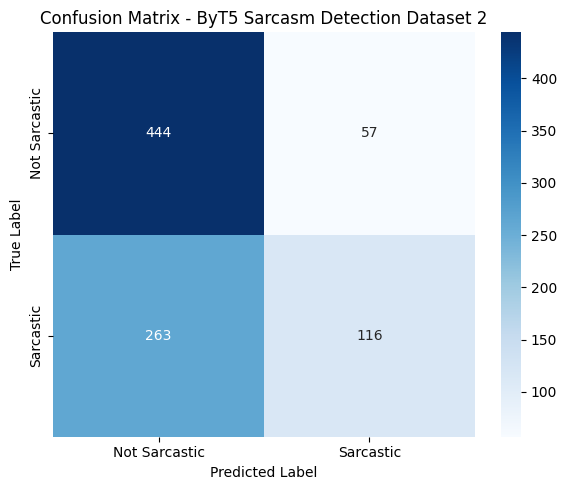

In [13]:
model.eval()
preds_byt5, truths_byt5 = [], []
with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        preds_byt5.extend(torch.argmax(logits, dim=1).cpu().numpy())
        truths_byt5.extend(b_labels.cpu().numpy())

print(classification_report(truths_byt5, preds_byt5, target_names=['Not Sarcastic', 'Sarcastic']))

cm_byt5 = confusion_matrix(truths_byt5, preds_byt5)
labels = ['Not Sarcastic', 'Sarcastic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_byt5, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - ByT5 Sarcasm Detection Dataset 2')
plt.tight_layout()
plt.show()

## With context

#### Loading dataset 2

In [14]:
df['input_text'] = df['response'] + ' [SEP] ' + 'Context: ' + df['context']

# Check the result
print(df[['input_text', 'label']].head())


                                          input_text  label
0  That's exactly what a country who made up a ho...      1
1  but it still snows [SEP] Context: Facts for th...      1
2  lol, you can't make this stuff up. [SEP] Conte...      0
3  He didn't drink the compliance [SEP] Context: ...      0
4  In the Half Life series, the reason Gordon Fre...      0


#### Prepare dataset 2

In [15]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    df['input_text'], df['label'],
    test_size=0.2, random_state=42, stratify=df['label']
)

train_df = pd.DataFrame({'input_text': X_train, 'label': y_train})
test_df = pd.DataFrame({'input_text': X_test, 'label': y_test})

print("Train and test splits saved!")

Train and test splits saved!


#### Training

In [16]:
train_df['input_text'] = train_df['input_text'].fillna("").astype(str)
test_df['input_text'] = test_df['input_text'].fillna("").astype(str)

X_train_byt5 = train_df['input_text'].tolist()
y_train_byt5 = train_df['label'].tolist()
X_test_byt5 = test_df['input_text'].tolist()
y_test_byt5 = test_df['label'].tolist()

In [17]:
tokenizer = AutoTokenizer.from_pretrained("google/byt5-small")

def tokenize(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,         # You can adjust for your dataset
        return_tensors='pt'
    )

X_train_enc_byt5 = tokenize(X_train_byt5)
X_test_enc_byt5 = tokenize(X_test_byt5)

In [18]:
train_dataset_byt5 = TensorDataset(
    X_train_enc_byt5['input_ids'],
    X_train_enc_byt5['attention_mask'],
    torch.tensor(y_train_byt5)
)

test_dataset_byt5 = TensorDataset(
    X_test_enc_byt5['input_ids'],
    X_test_enc_byt5['attention_mask'],
    torch.tensor(y_test_byt5)
)

In [19]:
batch_size = 24

train_loader = DataLoader(train_dataset_byt5, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset_byt5, batch_size=batch_size)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModelForSequenceClassification.from_pretrained("google/byt5-small", num_labels=2)
model = model.to(device)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/byt5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
optimizer = AdamW(model.parameters(), lr=3e-5)

#### Training loop


In [22]:
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask, labels=b_labels)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

model.save_pretrained('byt5_with_context_2')

100%|██████████| 147/147 [04:15<00:00,  1.74s/it]


Epoch 1 Loss: 0.6865


100%|██████████| 147/147 [04:15<00:00,  1.74s/it]


Epoch 2 Loss: 0.6773


100%|██████████| 147/147 [04:15<00:00,  1.74s/it]


Epoch 3 Loss: 0.6723


100%|██████████| 147/147 [04:15<00:00,  1.74s/it]


Epoch 4 Loss: 0.6697


100%|██████████| 147/147 [04:15<00:00,  1.74s/it]


Epoch 5 Loss: 0.6619


#### Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained('byt5_with_context_2')
model = model.to(device)

               precision    recall  f1-score   support

Not Sarcastic       0.62      0.83      0.71       501
    Sarcastic       0.60      0.34      0.43       379

     accuracy                           0.62       880
    macro avg       0.61      0.58      0.57       880
 weighted avg       0.61      0.62      0.59       880



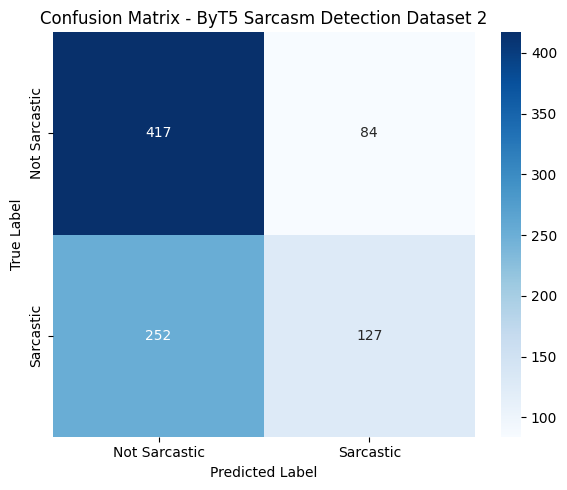

In [23]:
model.eval()
preds_byt5, truths_byt5 = [], []
with torch.no_grad():
    for batch in test_loader:
        b_input_ids, b_attn_mask, b_labels = [x.to(device) for x in batch]
        outputs = model(input_ids=b_input_ids, attention_mask=b_attn_mask)
        logits = outputs.logits
        preds_byt5.extend(torch.argmax(logits, dim=1).cpu().numpy())
        truths_byt5.extend(b_labels.cpu().numpy())

print(classification_report(truths_byt5, preds_byt5, target_names=['Not Sarcastic', 'Sarcastic']))

cm_byt5 = confusion_matrix(truths_byt5, preds_byt5)
labels = ['Not Sarcastic', 'Sarcastic']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_byt5, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - ByT5 Sarcasm Detection Dataset 2 with context')
plt.tight_layout()
plt.show()